<h1> Logistic Regression using Spark ML </h1>

Set up bucket

In [53]:
BUCKET='cloud-training-demos-ml'

os.environ['BUCKET'] = BUCKET

In a standalone script, we'd have to do:
<pre>
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bayes classification using Spark") \
    .getOrCreate()
</pre>
But in Datalab, spark already exists

In [29]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

In [30]:
print spark

<h2> Read dataset </h2>

In [13]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://cloud-training-demos-ml/flights/trainday.csv')
traindays.createOrReplaceTempView('traindays')

In [14]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])

In [17]:
inputs = 'gs://cloud-training-demos-ml/flights/tzcorr/all_flights-00000-*' # 1/30th
#inputs = 'gs://cloud-training-demos-ml/flights/tzcorr/all_flights-*'  # FULL
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

<h2> Logistic regression </h2>

In [36]:
trainquery = """
SELECT
  *
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)

In [37]:
traindata.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            258706|            258706|           258706|           258706|
|   mean|13.037455644631358| 16.95628242097207| 9.73190030381978|808.0081868994148|
| stddev|41.430889659075206|10.919038144347908|45.03845702691162|595.6178550480842|
|    min|             -61.0|               1.0|            -77.0|             31.0|
|    max|            1587.0|             225.0|           1627.0|           4983.0|
+-------+------------------+------------------+-----------------+-----------------+



In [39]:
def to_example(fields):
  return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime \
              [ \
                  fields['DEP_DELAY'], # DEP_DELAY \
                  fields['TAXI_OUT'], # TAXI_OUT \
                  fields['DISTANCE'], # DISTANCE \
              ])

In [40]:
examples = traindata.rdd.map(to_example)

In [41]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print lrmodel.weights,lrmodel.intercept

[-0.164547166127,-0.132371243776,0.000294013861929] 5.15793837988


In [42]:
lrmodel.setThreshold(0.7) # cancel if prob-of-ontime < 0.7

<h2> Evaluate model </h2>

Evaluate on the test data

In [43]:
testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")
print testquery


SELECT
  *
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL



In [44]:
testdata = spark.sql(testquery)

In [45]:
examples = testdata.rdd.map(to_example)

In [50]:
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
def eval(labelpred):
    cancel = labelpred.filter(lambda (label, pred): pred == 0)
    nocancel = labelpred.filter(lambda (label, pred): pred == 1)
    corr_cancel = cancel.filter(lambda (label, pred): label == pred).count()
    corr_nocancel = nocancel.filter(lambda (label, pred): label == pred).count()
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel.count(), \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel.count() \
           }
print eval(labelpred)

{'correct_cancel': 0.7917474551623849, 'total_noncancel': 115949, 'correct_noncancel': 0.9571363271783284, 'total_cancel': 33008}


<h2> Predict with the model </h2>

First save the model

In [56]:
!gsutil -m rm -r gs://$BUCKET/flights/sparkmloutput/model

CommandException: 1 files/objects could not be removed.


In [57]:
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'
lrmodel.save(sc, MODEL_FILE)

In [59]:
lrmodel = 0
print lrmodel

0


Now retrieve the model

In [62]:
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

In [63]:
print lrmodel.predict([36.0,12.0,594.0])

0


In [64]:
print lrmodel.predict([8.0,4.0,594.0])

1


<h2> Examine the model behavior </h2>

For dep_delay=20 and taxiout=10, how does the distance affect prediction?

In [82]:
lrmodel.clearThreshold() # to make the model produce probabilities
print lrmodel.predict([20, 10, 500])

0.666031335615


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]

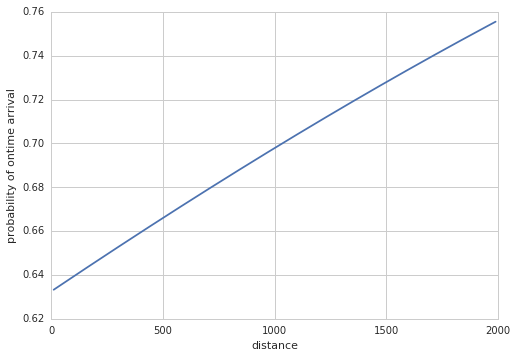

In [85]:
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance')
plt.ylabel('probability of ontime arrival')